# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [145]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from dl4cv.classifiers.fc_net import *
from dl4cv.data_utils import get_CIFAR10_data
from dl4cv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl4cv.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (48000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)


y_val:  (1000,)
y_train:  (48000,)
y_test:  (1000,)


# Affine layer: foward
Open the file `dl4cv/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [147]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)
out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print 'Testing affine_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing affine_forward function:
difference:  9.76984946819e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [148]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print 'Testing affine_backward function:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_backward function:
dx error:  4.23369068902e-10
dw error:  4.20388903088e-10
db error:  1.45618905713e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [149]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print 'Testing relu_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [150]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print 'Testing relu_backward function:'
print 'dx error: ', rel_error(dx_num, dx)

Testing relu_backward function:
dx error:  3.27561965835e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `dl4cv/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [151]:
from dl4cv.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print 'Testing affine_relu_forward:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_relu_forward:
dx error:  4.55610413668e-11
dw error:  2.39416575478e-10
db error:  1.51096158528e-11


# Loss layers: Softmax
You implemented this loss function in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `dl4cv/layers.py`.

You can make sure that the implementations are correct by running the following:

In [152]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print '\nTesting softmax_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)


Testing softmax_loss:
loss:  2.30261825516


dx error:  7.66363239045e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `dl4cv/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [153]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print 'Testing initialization ... '
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print 'Testing test-time forward pass ... '
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print 'Testing training loss (no regularization)'
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print 'Running numeric gradient check with reg = ', reg
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Testing initialization ... 


Testing test-time forward pass ... 
Testing training loss (no regularization)


Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08


W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `dl4cv/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [154]:
model = TwoLayerNet(reg=0.19)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
pass
solver = Solver(model, 
                data=data,
                num_epochs=10,
                lr_decay=0.95,
                batch_size=300,
                print_every=100,
                optim_config={
                      'learning_rate': 0.00123456,
                    })
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1600) loss: 2.330496


(Epoch 0 / 10) train acc: 0.179000; val_acc: 0.184000


(Iteration 101 / 1600) loss: 1.695972


(Epoch 1 / 10) train acc: 0.412000; val_acc: 0.422000


(Iteration 201 / 1600) loss: 1.683472


(Iteration 301 / 1600) loss: 1.585647


(Epoch 2 / 10) train acc: 0.452000; val_acc: 0.459000


(Iteration 401 / 1600) loss: 1.684263


(Epoch 3 / 10) train acc: 0.508000; val_acc: 0.469000


(Iteration 501 / 1600) loss: 1.515360


(Iteration 601 / 1600) loss: 1.709883


(Epoch 4 / 10) train acc: 0.495000; val_acc: 0.482000


(Iteration 701 / 1600) loss: 1.484689


(Epoch 5 / 10) train acc: 0.519000; val_acc: 0.495000
(Iteration 801 / 1600) loss: 1.437399


(Iteration 901 / 1600) loss: 1.428332


(Epoch 6 / 10) train acc: 0.541000; val_acc: 0.505000


(Iteration 1001 / 1600) loss: 1.320907


(Iteration 1101 / 1600) loss: 1.349895


(Epoch 7 / 10) train acc: 0.549000; val_acc: 0.491000


(Iteration 1201 / 1600) loss: 1.358594


(Epoch 8 / 10) train acc: 0.507000; val_acc: 0.485000


(Iteration 1301 / 1600) loss: 1.340172


(Iteration 1401 / 1600) loss: 1.270727


(Epoch 9 / 10) train acc: 0.581000; val_acc: 0.493000


(Iteration 1501 / 1600) loss: 1.278662


(Epoch 10 / 10) train acc: 0.577000; val_acc: 0.498000


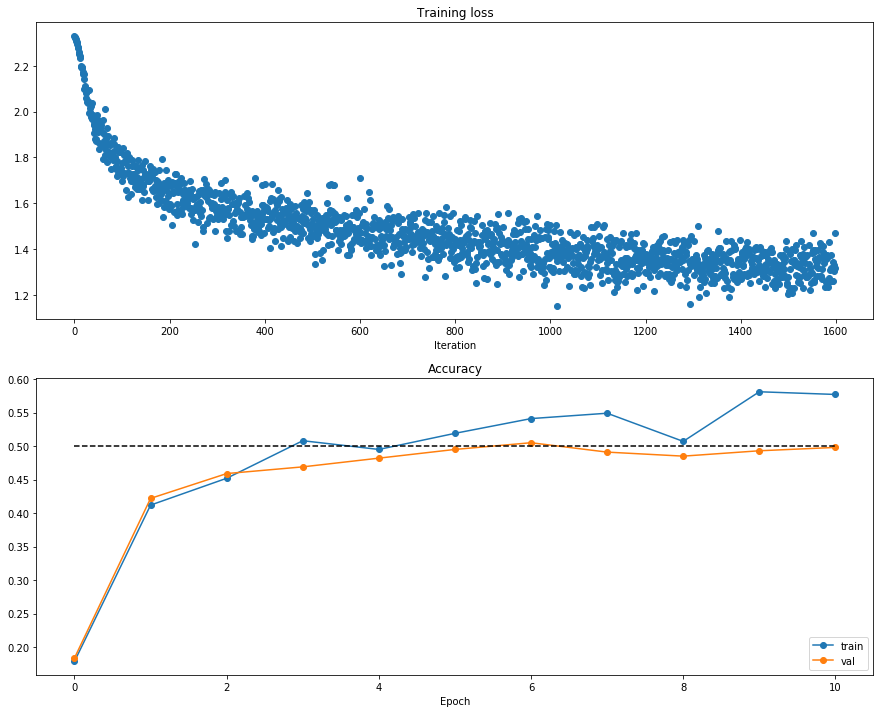

In [155]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `dl4cv/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [156]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Running check with reg =  0


Initial loss:  2.303400507
W1 relative error: 3.04e-02


W2 relative error: 1.46e-01
W3 relative error: 1.61e-07
b1 relative error: 2.47e-09
b2 relative error: 1.15e-01
b3 relative error: 1.72e-10
Running check with reg =  3.14
Initial loss:  7.13568426824


W1 relative error: 2.12e-08
W2 relative error: 1.33e-07


W3 relative error: 2.22e-08
b1 relative error: 1.19e-08
b2 relative error: 3.58e-08
b3 relative error: 2.33e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.334249


(Epoch 0 / 20) train acc: 0.340000; val_acc: 0.101000


(Epoch 1 / 20) train acc: 0.440000; val_acc: 0.148000
(Epoch 2 / 20) train acc: 0.660000; val_acc: 0.135000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.129000
(Epoch 4 / 20) train acc: 0.600000; val_acc: 0.145000
(Epoch 5 / 20) train acc: 0.720000; val_acc: 0.156000
(Iteration 11 / 40) loss: 1.177584
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.171000


(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.160000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.170000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.154000
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.139000
(Iteration 21 / 40) loss: 0.491063
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.168000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.150000


(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.158000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.171000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.166000
(Iteration 31 / 40) loss: 0.068543
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.165000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.167000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.172000


(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.172000
(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.170000


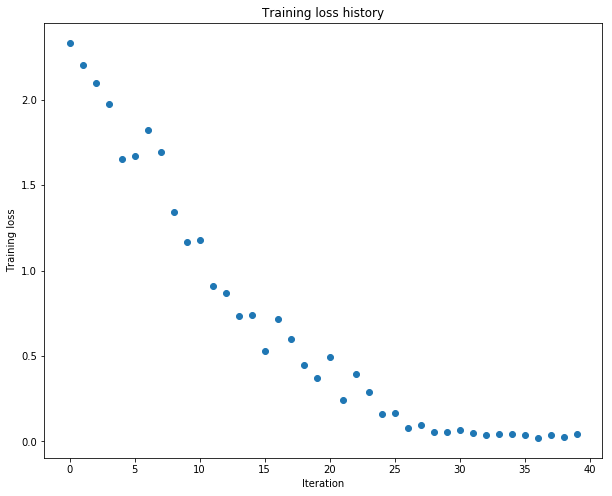

In [157]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = .01
model = FullyConnectedNet([100, 100],
                          weight_scale=weight_scale, 
                          dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, 
                num_epochs=20, 
                batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.497176
(Epoch 0 / 20) train acc: 0.400000; val_acc: 0.102000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.113000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.136000
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.140000


(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.119000
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.152000
(Iteration 11 / 40) loss: 0.888287
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.143000
(Epoch 7 / 20) train acc: 0.780000; val_acc: 0.164000


(Epoch 8 / 20) train acc: 0.800000; val_acc: 0.139000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.144000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.164000
(Iteration 21 / 40) loss: 0.134698
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.191000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.172000


(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.180000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.173000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.174000
(Iteration 31 / 40) loss: 0.019606
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.187000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.175000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.182000


(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.179000
(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.183000


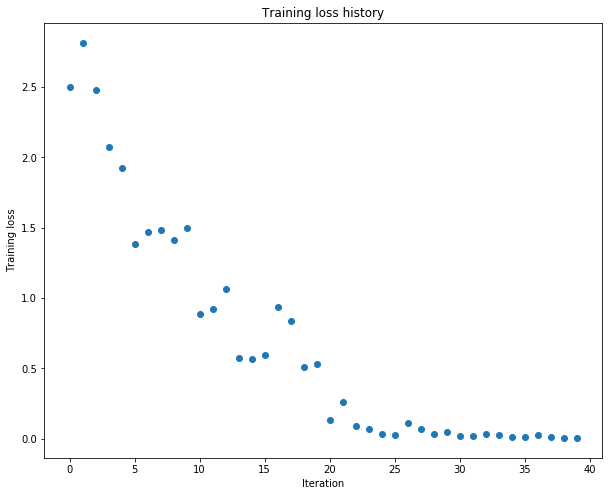

In [158]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 0.04
learning_rate = 0.04
model = FullyConnectedNet([100, 100, 100, 100],
                          weight_scale=weight_scale, 
                          dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, 
                num_epochs=20, 
                batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

**Your answer:** *It is very difficult to find the sweet spot of the training parameters. Accuracy fluctuates a lot even on a very small change of parameters*


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `dl4cv/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [159]:
from dl4cv.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print 'next_w error: ', rel_error(next_w, expected_next_w)
print 'velocity error: ', rel_error(expected_velocity, config['velocity'])

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd


(Iteration 1 / 200) loss: 2.649630
(Epoch 0 / 5) train acc: 0.088000; val_acc: 0.089000
(Iteration 11 / 200) loss: 2.295825
(Iteration 21 / 200) loss: 2.166213


(Iteration 31 / 200) loss: 2.231176
(Epoch 1 / 5) train acc: 0.236000; val_acc: 0.201000
(Iteration 41 / 200) loss: 2.011884
(Iteration 51 / 200) loss: 1.981205


(Iteration 61 / 200) loss: 1.845671
(Iteration 71 / 200) loss: 2.029893
(Epoch 2 / 5) train acc: 0.341000; val_acc: 0.257000


(Iteration 81 / 200) loss: 1.816494
(Iteration 91 / 200) loss: 1.828246
(Iteration 101 / 200) loss: 1.900032


(Iteration 111 / 200) loss: 1.789288
(Epoch 3 / 5) train acc: 0.370000; val_acc: 0.279000
(Iteration 121 / 200) loss: 1.789185
(Iteration 131 / 200) loss: 1.749679


(Iteration 141 / 200) loss: 1.722525
(Iteration 151 / 200) loss: 1.659195


(Epoch 4 / 5) train acc: 0.409000; val_acc: 0.291000
(Iteration 161 / 200) loss: 1.750991
(Iteration 171 / 200) loss: 1.621204


(Iteration 181 / 200) loss: 1.605634
(Iteration 191 / 200) loss: 1.716007
(Epoch 5 / 5) train acc: 0.409000; val_acc: 0.320000

running with  sgd_momentum


(Iteration 1 / 200) loss: 2.991278
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.085000
(Iteration 11 / 200) loss: 2.234722


(Iteration 21 / 200) loss: 1.994609
(Iteration 31 / 200) loss: 1.890785
(Epoch 1 / 5) train acc: 0.305000; val_acc: 0.251000


(Iteration 41 / 200) loss: 1.879280
(Iteration 51 / 200) loss: 2.001230


(Iteration 61 / 200) loss: 1.679443
(Iteration 71 / 200) loss: 1.650507


(Epoch 2 / 5) train acc: 0.402000; val_acc: 0.314000
(Iteration 81 / 200) loss: 1.831808
(Iteration 91 / 200) loss: 1.722692
(Iteration 101 / 200) loss: 1.557521


(Iteration 111 / 200) loss: 1.786121
(Epoch 3 / 5) train acc: 0.444000; val_acc: 0.339000
(Iteration 121 / 200) loss: 1.626902


(Iteration 131 / 200) loss: 1.427509
(Iteration 141 / 200) loss: 1.450750


(Iteration 151 / 200) loss: 1.354359


(Epoch 4 / 5) train acc: 0.502000; val_acc: 0.348000
(Iteration 161 / 200) loss: 1.385705
(Iteration 171 / 200) loss: 1.530994


(Iteration 181 / 200) loss: 1.332920
(Iteration 191 / 200) loss: 1.464357


(Epoch 5 / 5) train acc: 0.519000; val_acc: 0.350000



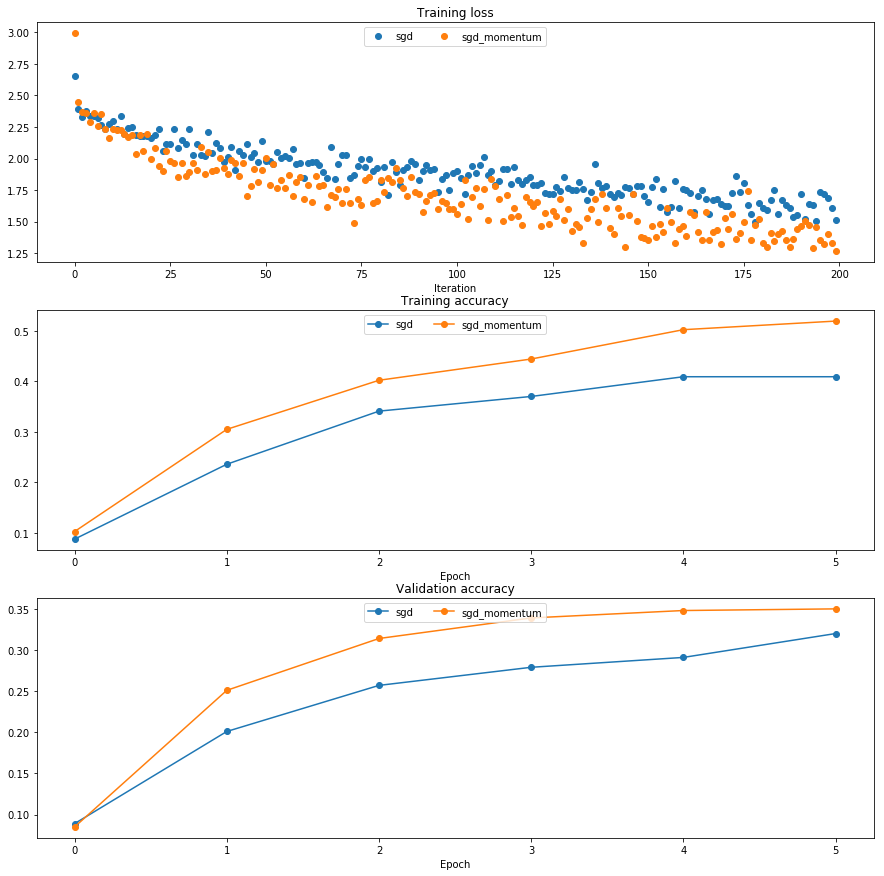

In [160]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

In the file `dl4cv/optim.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

running with  adam


(Iteration 1 / 400) loss: 3.291822
(Epoch 0 / 10) train acc: 0.118000; val_acc: 0.087000


(Iteration 11 / 400) loss: 2.117345
(Iteration 21 / 400) loss: 1.875659


(Iteration 31 / 400) loss: 1.869141
(Epoch 1 / 10) train acc: 0.392000; val_acc: 0.310000
(Iteration 41 / 400) loss: 1.912519


(Iteration 51 / 400) loss: 1.655795
(Iteration 61 / 400) loss: 1.664757


(Iteration 71 / 400) loss: 1.642138
(Epoch 2 / 10) train acc: 0.467000; val_acc: 0.346000
(Iteration 81 / 400) loss: 1.586628


(Iteration 91 / 400) loss: 1.560153
(Iteration 101 / 400) loss: 1.595416


(Iteration 111 / 400) loss: 1.424619
(Epoch 3 / 10) train acc: 0.473000; val_acc: 0.334000
(Iteration 121 / 400) loss: 1.344697


(Iteration 131 / 400) loss: 1.602317
(Iteration 141 / 400) loss: 1.208683


(Iteration 151 / 400) loss: 1.378271
(Epoch 4 / 10) train acc: 0.566000; val_acc: 0.358000
(Iteration 161 / 400) loss: 1.129323


(Iteration 171 / 400) loss: 1.266057
(Iteration 181 / 400) loss: 1.235083


(Iteration 191 / 400) loss: 1.038987
(Epoch 5 / 10) train acc: 0.540000; val_acc: 0.341000
(Iteration 201 / 400) loss: 1.180592


(Iteration 211 / 400) loss: 1.204674
(Iteration 221 / 400) loss: 0.871665


(Iteration 231 / 400) loss: 0.919477
(Epoch 6 / 10) train acc: 0.634000; val_acc: 0.388000
(Iteration 241 / 400) loss: 1.229484


(Iteration 251 / 400) loss: 1.009773
(Iteration 261 / 400) loss: 0.893836


(Iteration 271 / 400) loss: 1.003200
(Epoch 7 / 10) train acc: 0.685000; val_acc: 0.359000
(Iteration 281 / 400) loss: 0.906846


(Iteration 291 / 400) loss: 0.961734
(Iteration 301 / 400) loss: 0.831528


(Iteration 311 / 400) loss: 0.990136
(Epoch 8 / 10) train acc: 0.682000; val_acc: 0.351000
(Iteration 321 / 400) loss: 1.138516


(Iteration 331 / 400) loss: 0.823769
(Iteration 341 / 400) loss: 0.948504


(Iteration 351 / 400) loss: 0.894979
(Epoch 9 / 10) train acc: 0.695000; val_acc: 0.357000
(Iteration 361 / 400) loss: 0.754182


(Iteration 371 / 400) loss: 0.860562
(Iteration 381 / 400) loss: 0.764111


(Iteration 391 / 400) loss: 0.726042
(Epoch 10 / 10) train acc: 0.742000; val_acc: 0.344000



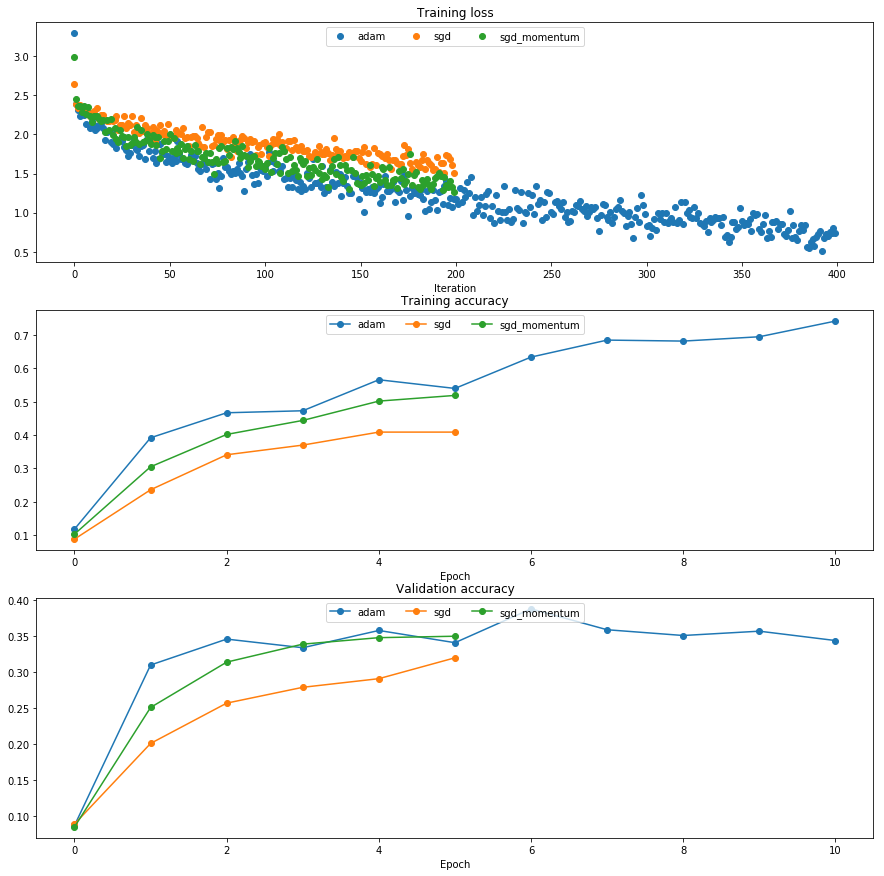

In [161]:
learning_rates = {'adam': 1e-3}
update_rule = 'adam'
print 'running with ', update_rule
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, small_data,
              num_epochs=10, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 48% accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` notebook before completing this part, since this technique can help you train powerful models.

(Iteration 1 / 4800) loss: 2.514402
(Epoch 0 / 10) train acc: 0.135000; val_acc: 0.161000


(Iteration 101 / 4800) loss: 1.849871


(Iteration 201 / 4800) loss: 1.644561


(Iteration 301 / 4800) loss: 1.661106


(Iteration 401 / 4800) loss: 1.354714


(Epoch 1 / 10) train acc: 0.439000; val_acc: 0.428000


(Iteration 501 / 4800) loss: 1.436364


(Iteration 601 / 4800) loss: 1.562703


(Iteration 701 / 4800) loss: 1.581203


(Iteration 801 / 4800) loss: 1.665234


(Iteration 901 / 4800) loss: 1.464540


(Epoch 2 / 10) train acc: 0.483000; val_acc: 0.437000


(Iteration 1001 / 4800) loss: 1.590882


(Iteration 1101 / 4800) loss: 1.370667


(Iteration 1201 / 4800) loss: 1.271024


(Iteration 1301 / 4800) loss: 1.469278


(Iteration 1401 / 4800) loss: 1.337307


(Epoch 3 / 10) train acc: 0.510000; val_acc: 0.469000


(Iteration 1501 / 4800) loss: 1.455444


(Iteration 1601 / 4800) loss: 1.422921


(Iteration 1701 / 4800) loss: 1.262129


(Iteration 1801 / 4800) loss: 1.371134


(Iteration 1901 / 4800) loss: 1.455474


(Epoch 4 / 10) train acc: 0.537000; val_acc: 0.493000


(Iteration 2001 / 4800) loss: 1.362188


(Iteration 2101 / 4800) loss: 1.290782


(Iteration 2201 / 4800) loss: 1.361092


(Iteration 2301 / 4800) loss: 1.096953


(Epoch 5 / 10) train acc: 0.544000; val_acc: 0.498000
(Iteration 2401 / 4800) loss: 1.358098


(Iteration 2501 / 4800) loss: 1.374369


(Iteration 2601 / 4800) loss: 1.228312


(Iteration 2701 / 4800) loss: 1.439474


(Iteration 2801 / 4800) loss: 1.390148


(Epoch 6 / 10) train acc: 0.561000; val_acc: 0.480000


(Iteration 2901 / 4800) loss: 1.336465


(Iteration 3001 / 4800) loss: 1.284510


(Iteration 3101 / 4800) loss: 1.166941


(Iteration 3201 / 4800) loss: 1.128551


(Iteration 3301 / 4800) loss: 1.402316


(Epoch 7 / 10) train acc: 0.571000; val_acc: 0.494000


(Iteration 3401 / 4800) loss: 1.202902


(Iteration 3501 / 4800) loss: 1.158787


(Iteration 3601 / 4800) loss: 1.052068


(Iteration 3701 / 4800) loss: 1.145601


(Iteration 3801 / 4800) loss: 1.174700


(Epoch 8 / 10) train acc: 0.569000; val_acc: 0.488000


(Iteration 3901 / 4800) loss: 1.256834


(Iteration 4001 / 4800) loss: 1.371199


(Iteration 4101 / 4800) loss: 1.140524


(Iteration 4201 / 4800) loss: 1.206154


(Iteration 4301 / 4800) loss: 1.085468


(Epoch 9 / 10) train acc: 0.580000; val_acc: 0.499000


(Iteration 4401 / 4800) loss: 1.072084


(Iteration 4501 / 4800) loss: 1.278053


(Iteration 4601 / 4800) loss: 1.192917


(Iteration 4701 / 4800) loss: 1.171175


(Epoch 10 / 10) train acc: 0.605000; val_acc: 0.525000
params : {'ws': 0.04, 'lr': 0.001} val_acc= 0.525


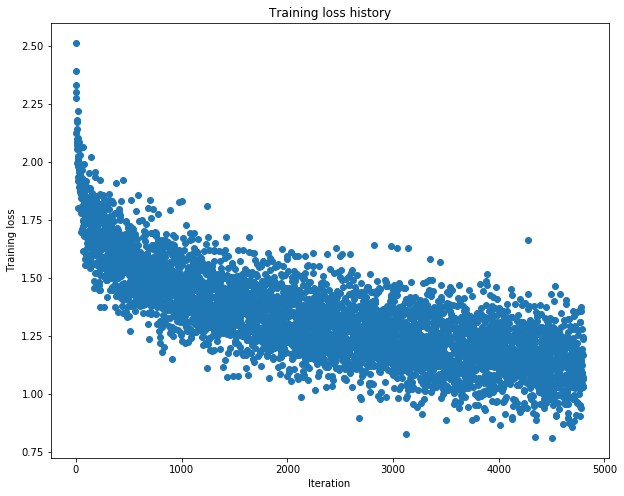

In [188]:
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################
pass
best_model = None
best_solver = None
best_val_acc = -1
weight_scales = [0.04]
learning_rates = [0.001]
best_hyper_params = {}
#weight_scales = np.logspace(-1.4, -1, 15)
#learning_rates = np.logspace(-3, -2.9, 15)
for weight_scale in weight_scales:
    for learning_rate in learning_rates:
        model = FullyConnectedNet([100, 100, 100, 100],
                                    weight_scale=weight_scale, 
                                    dtype=np.float64)
        solver = Solver(model, data,
                            print_every=100, 
                            num_epochs=10, 
                            batch_size=300,
                            update_rule='adam',
                            verbose=True,
                            optim_config={
                                'learning_rate': learning_rate,
                            }
                        )
        solver.train()
        print("params : "+str(solver.best_hyperparams)+" val_acc= "+str(solver.val_acc_history[-1]))
        if solver.val_acc_history[-1] > best_val_acc:
            best_hyper_params = solver.best_hyperparams
            best_val_acc = solver.val_acc_history[-1]
            best_model = model
            best_solver = solver
                        
plt.plot(best_solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test you model
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set.

In [190]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']
y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print 'Validation set accuracy: ', (y_val_pred == y_val).mean()
print 'Test set accuracy: ', (y_test_pred == y_test).mean()

Validation set accuracy:  0.525
Test set accuracy:  0.505


## Save the model

When you are satisfied with your training, save the model for submission.

In [191]:
from dl4cv.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.48 \\
        \left(\frac{48}{\exp(0.48 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.48 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.48, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')